Sealevel monitor
========

This document is used to monitor the current sea level along the Dutch coast. The sea level is measured using a number of tide gauges. Six long running tide gauges are considered "main stations". The mean of these stations is used to estimate the "current sea-level rise". The measurements since 1890 are taken into account. Measurements before that are considered less valid because the Amsterdam Ordnance Datum was not yet normalized. 

In [1]:
# this is a list of packages that are used in this notebook
# these come with python
import io
import zipfile
import functools
import bisect
import datetime
import pathlib

import sys
before = {str(m) for m in sys.modules}
# you can install these packages using pip or anaconda
# (requests numpy pandas bokeh pyproj statsmodels)

# for downloading
import requests
import netCDF4

# computation libraries
import numpy as np
import pandas as pd


# coordinate systems
import pyproj 

# statistics
import statsmodels.api as sm
import statsmodels.multivariate.pca
import statsmodels.tsa.seasonal


# plotting
import bokeh.io
import bokeh.plotting
import bokeh.tile_providers
import bokeh.palettes
from bokeh.io import export_png

# this package gives a lot of warnings about incompatibility with 3.1 
# replace 
import windrose
import matplotlib.colors
import matplotlib.cm
import matplotlib.pyplot as plt
matplotlib.projections.register_projection(windrose.WindroseAxes)
import cmocean.cm

# displaying things
from ipywidgets import Image
import IPython.display

C:\Users\marti_cn\AppData\Local\Continuum\anaconda3\envs\searise\lib\site-packages\windrose\windrose.py:29: MatplotlibDeprecationWarning: 
The Appender class was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  addendum = docstring.Appender(msg, "\n\n")
C:\Users\marti_cn\AppData\Local\Continuum\anaconda3\envs\searise\lib\site-packages\windrose\windrose.py:30: MatplotlibDeprecationWarning: 
The copy_dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use docstring.copy() and cbook.dedent() instead.
  return lambda func: addendum(docstring.copy_dedent(base)(func))
C:\Users\marti_cn\AppData\Local\Continuum\anaconda3\envs\searise\lib\site-packages\windrose\windrose.py:30: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.getdoc() instead.
  return lambda func: addendum(docstring.copy_dedent(base)(func))
C:\Users\marti_cn\AppData\Local\Continuum\anaconda3\envs\searise\lib\site-packag

In [2]:
# Some coordinate systems
WEBMERCATOR = pyproj.Proj(init='epsg:3857')
WGS84 = pyproj.Proj(init='epsg:4326')

# If this notebook is not showing up with figures, you can use the following url:
# https://nbviewer.ipython.org/github/openearth/notebooks/blob/master/sealevelmonitor.ipynb
bokeh.io.output_notebook()
# we're using matplotlib for polar plots (non-interactive)
%matplotlib inline
# does not work properly
# %matplotlib notebook

# use local data, make sure you updated the datasets with the makefiles
local = False#True

C:\Users\marti_cn\AppData\Local\Continuum\anaconda3\envs\searise\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\marti_cn\AppData\Local\Continuum\anaconda3\envs\searise\lib\site-packages\pyproj\crs\crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
C:\Users\marti_cn\AppData\Local\Continuum\anaconda3\envs\searise\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:

Loading BokehJS ...

Sea-level measurements
=============
In this section we download sea-level measurements. The global collection of tide gauge records at the PSMSL is used to access the data. The other way to access the data is to ask the service desk data at Rijkswaterstaat. There are two types of datasets the "Revised Local Reference" and "Metric". For the Netherlands the difference is that the "Revised Local Reference" undoes the corrections from the  NAP correction in 2014, to get a consistent dataset. Here we transform the RLR back to NAP (without undoing the correction).

In [3]:
psmsl_urls_remote = {
    'met_monthly': 'http://www.psmsl.org/data/obtaining/met.monthly.data/met_monthly.zip',
    'rlr_monthly': 'http://www.psmsl.org/data/obtaining/rlr.monthly.data/rlr_monthly.zip',
    'rlr_annual': 'http://www.psmsl.org/data/obtaining/rlr.annual.data/rlr_annual.zip'
}
psmsl_data_dir = pathlib.Path('~/src/sealevel/data/psmsl').expanduser()
psmsl_urls_local = {
    'met_monthly': psmsl_data_dir / 'met_monthly.zip',
    'rlr_monthly': psmsl_data_dir / 'rlr_monthly.zip',
    'rlr_annual': psmsl_data_dir / 'rlr_annual.zip'
}
if local:
    psmsl_urls = psmsl_urls_local
else:
    psmsl_urls = psmsl_urls_remote
default_dataset_name = 'rlr_annual'

In [4]:
# the rlrnap computes the rlr back to  latest NAP (ignoring the undoing of the NAP correction)
# the alpha paramater is the dominant wind direction for the stations, based on de Ronde 2013
# id's are the station ids in the PSMSL dataset

# Make sure that you verify the rlr2nap parameters. They may change from year to year  as the PSMSL 0 point is arbitary.
# You can lookup the relevant parameters in the schematic diagram like this:
# https://www.psmsl.org/data/obtaining/rlr.diagrams/20.php
main_stations = [
    {
        'id': 20,
        'name': 'Vlissingen', 
        'rlr2nap': lambda x: x - (6976-46),
        'alpha': 118
    },
    {
        'id': 22,
        'name': 'Hoek van Holland', 
        'rlr2nap': lambda x:x - (6987 - 114),
        'alpha': 117
    },
    {
        'id': 23,
        'name': 'Den Helder', 
        'rlr2nap': lambda x: x - (6962 - 16),
        'alpha': 107
    },
    {
        'id': 24,
        'name': 'Delfzijl', 
        'rlr2nap': lambda x: x - (6953 - 13),
        'alpha': 117
    },
    {
        'id': 25,
        'name': 'Harlingen', 
        'rlr2nap': lambda x: x - (7024 - 11),
        'alpha': 108
    },
    {
        'id': 32,
        'name': 'IJmuiden', 
        'rlr2nap': lambda x: x - (7014 - 64),
        'alpha': 110
    }
]
main_stations = pd.DataFrame(main_stations).set_index('id')
main_stations

,name,rlr2nap,alpha
id,,,
20,Vlissingen,<function <lambda> at 0x0000016BBEE3F840>,118
22,Hoek van Holland,<function <lambda> at 0x0000016BBEE3F7B8>,117
23,Den Helder,<function <lambda> at 0x0000016BBEE3F730>,107
24,Delfzijl,<function <lambda> at 0x0000016BBEE3FAE8>,117
25,Harlingen,<function <lambda> at 0x0000016BBEE3FB70>,108
32,IJmuiden,<function <lambda> at 0x0000016BBEE3FBF8>,110


In [5]:
# the main stations are defined by their ids
main_stations_idx = list(main_stations.index)
main_stations_idx

[20, 22, 23, 24, 25, 32]

In [6]:
# download the zipfile

zipfiles = {}


for dataset_name in psmsl_urls:
    if local:
        zf = zipfile.ZipFile(psmsl_urls_local[dataset_name])
    else:
        resp = requests.get(psmsl_urls_remote[dataset_name])
        # we can read the zipfile
        stream = io.BytesIO(resp.content)
        zf = zipfile.ZipFile(stream)
    zipfiles[dataset_name] = zf

# this list contains a table of 
# station ID, latitude, longitude, station name, coastline code, station code, and quality flag
csvtext = zipfiles[dataset_name].read('{}/filelist.txt'.format(dataset_name))

stations = pd.read_csv(
    io.BytesIO(csvtext), 
    sep=';',
    names=('id', 'lat', 'lon', 'name', 'coastline_code', 'station_code', 'quality'),
    converters={
        'name': str.strip,
        'quality': str.strip
    }
)
stations = stations.set_index('id')

# the dutch stations in the PSMSL database, make a copy
# or use stations.coastline_code == 150 for all dutch stations
selected_stations = pd.merge(main_stations, stations, left_index=True, right_index=True)
# set the main stations, this should be a list of 6 stations
selected_stations['name'] = selected_stations['name_x']
selected_stations

,name_x,rlr2nap,alpha,lat,lon,name_y,coastline_code,station_code,quality,name
id,,,,,,,,,,
20,Vlissingen,<function <lambda> at 0x0000016BBEE3F840>,118,51.442222,3.596111,VLISSINGEN,150,101,N,Vlissingen
22,Hoek van Holland,<function <lambda> at 0x0000016BBEE3F7B8>,117,51.977500,4.120000,HOEK VAN HOLLAND,150,51,N,Hoek van Holland
23,Den Helder,<function <lambda> at 0x0000016BBEE3F730>,107,52.964444,4.745000,DEN HELDER,150,31,N,Den Helder
24,Delfzijl,<function <lambda> at 0x0000016BBEE3FAE8>,117,53.326389,6.933056,DELFZIJL,150,1,N,Delfzijl
25,Harlingen,<function <lambda> at 0x0000016BBEE3FB70>,108,53.175556,5.409444,HARLINGEN,150,21,N,Harlingen
32,IJmuiden,<function <lambda> at 0x0000016BBEE3FBF8>,110,52.462222,4.554722,IJMUIDEN,150,41,N,IJmuiden


In [8]:
# show all the stations on a map

# compute the bounds of the plot
sw = (50, -5)
ne = (55, 10)
# transform to web mercator
sw_wm = pyproj.transform(WGS84, WEBMERCATOR, sw[1], sw[0])
ne_wm = pyproj.transform(WGS84, WEBMERCATOR, ne[1], ne[0])
# create a plot
fig = bokeh.plotting.figure(tools='pan, wheel_zoom', plot_width=600, plot_height=200, x_range=(sw_wm[0], ne_wm[0]), y_range=(sw_wm[1], ne_wm[1]))
fig.axis.visible = False
# add some background tiles
#fig.add_tile(bokeh.tile_providers.STAMEN_TERRAIN)
# add the stations
x, y = pyproj.transform(WGS84, WEBMERCATOR, np.array(stations.lon), np.array(stations.lat))
fig.circle(x, y)
x, y = pyproj.transform(WGS84, WEBMERCATOR, np.array(selected_stations.lon), np.array(selected_stations.lat))
_ = fig.circle(x, y, color='red')


# show the plot
bokeh.io.show(fig)

C:\Users\marti_cn\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:7: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  import sys
C:\Users\marti_cn\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:8: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  
C:\Users\marti_cn\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:15: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  from ipykernel import kernelapp as app
C:\Users\marti_cn\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:17: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


Now that we have defined which tide gauges we are monitoring we can start downloading the relevant data. 

In [9]:
# each station has a number of files that you can look at.
# here we define a template for each filename

# stations that we are using for our computation
# define the name formats for the relevant files
url_names = {
    'datum': '{dataset_name}/RLR_info/{id}.txt',
    'diagram': '{dataset_name}/RLR_info/{id}.png',
    'url': 'http://www.psmsl.org/data/obtaining/rlr.diagrams/{id}.php',
    'rlr_monthly': '{dataset_name}/data/{id}.rlrdata',
    'rlr_annual': '{dataset_name}/data/{id}.rlrdata',
    'met_monthly': '{dataset_name}/data/{id}.metdata',
    'doc': '{dataset_name}/docu/{id}.txt',
    'contact': '{dataset_name}/docu/{id}_auth.txt'
}

In [10]:
def get_url(station, dataset_name):
    """return the url of the station information (diagram and datum)"""
    info = dict(
        dataset_name=dataset_name,
        id=station.name
    )
    url = url_names['url'].format(**info)
    return url

#selected_stations= pd.DataFrame()
for dataset_name in psmsl_urls:
    # fill in the dataset parameter using the global dataset_name
    f = functools.partial(get_url, dataset_name=dataset_name)
    # compute the url for each station
    selected_stations[dataset_name] = selected_stations.apply(f, axis=1)
selected_stations

,name_x,rlr2nap,alpha,lat,lon,name_y,coastline_code,station_code,quality,name,met_monthly,rlr_monthly,rlr_annual
id,,,,,,,,,,,,,
20,Vlissingen,<function <lambda> at 0x0000016BBEE3F840>,118,51.442222,3.596111,VLISSINGEN,150,101,N,Vlissingen,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...
22,Hoek van Holland,<function <lambda> at 0x0000016BBEE3F7B8>,117,51.977500,4.120000,HOEK VAN HOLLAND,150,51,N,Hoek van Holland,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...
23,Den Helder,<function <lambda> at 0x0000016BBEE3F730>,107,52.964444,4.745000,DEN HELDER,150,31,N,Den Helder,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...
24,Delfzijl,<function <lambda> at 0x0000016BBEE3FAE8>,117,53.326389,6.933056,DELFZIJL,150,1,N,Delfzijl,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...
25,Harlingen,<function <lambda> at 0x0000016BBEE3FB70>,108,53.175556,5.409444,HARLINGEN,150,21,N,Harlingen,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...
32,IJmuiden,<function <lambda> at 0x0000016BBEE3FBF8>,110,52.462222,4.554722,IJMUIDEN,150,41,N,IJmuiden,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...


Sea-level explained  
=======
The sea-level is dependent on several factors. We call these factors explanatory, exogenous or independent variables. The main factors that influence the monthly and annual sea level include wind, pressure, river discharge, tide and oscilations in the ocean. Based on previous analysis we include wind and nodal tide as independent variables. To be able to include wind, we use the monthly 10m wind based on the NCEP reanlysis of the NCAR. To be more specific we include the squared u and v wind components. Unfortunately the wind series only go back to 1948. To be able to include them without having to discard the sea level measurements before 1948, we fill in the missing data with the mean. 

We don't include timeseries of volume based explanatory variables like 

In [11]:
def make_wind_df(lat_i=53, lon_i=3):
    """create a dataset for wind, for 1 latitude/longitude"""
    # the following url's are not available during a government shutdown
    u_file = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/surface_gauss/uwnd.10m.mon.mean.nc'
    v_file = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/surface_gauss/vwnd.10m.mon.mean.nc'
    
    if local:
        u_file = pathlib.Path('~/src/sealevel/data/noaa/uwnd.10m.mon.mean.nc').expanduser()
        v_file = pathlib.Path('~/src/sealevel/data/noaa/vwnd.10m.mon.mean.nc').expanduser()

    # open the 2 files
    ds_u = netCDF4.Dataset(u_file)
    ds_v = netCDF4.Dataset(v_file)
    
    # read lat,lon, time from 1 dataset
    lat, lon, time = ds_u.variables['lat'][:], ds_u.variables['lon'][:], ds_u.variables['time'][:]
    
    # check with the others
    lat_v, lon_v, time_v = ds_v.variables['lat'][:], ds_v.variables['lon'][:], ds_v.variables['time'][:]
    assert (lat == lat_v).all() and (lon == lon_v).all() and (time == time_v).all()
    
    # convert to datetime
    t = netCDF4.num2date(time, ds_u.variables['time'].units, only_use_cftime_datetimes= False)
    
    
    def find_closest(lat, lon, lat_i=lat_i, lon_i=lon_i):
        """lookup the index of the closest lat/lon"""
        Lon, Lat = np.meshgrid(lon, lat)
        idx = np.argmin(((Lat - lat_i)**2 + (Lon - lon_i)**2))
        Lat.ravel()[idx], Lon.ravel()[idx]
        [i, j] = np.unravel_index(idx, Lat.shape)
        return i, j
    
    # this is the index where we want our data
    i, j = find_closest(lat, lon)
    
    # get the u, v variables
    print('found point', lat[i], lon[j])
    u = ds_u.variables['uwnd'][:, i, j]
    v = ds_v.variables['vwnd'][:, i, j]

    # compute derived quantities
    speed = np.sqrt(u**2 + v**2)
    
    # compute direction in 0-2pi domain
    direction = np.mod(np.angle(u + v * 1j), 2*np.pi)
    
    # put everything in a dataframe
    wind_df = pd.DataFrame(data=dict(u=u, v=v, t=t, speed=speed, direction=direction))
    wind_df = wind_df.set_index('t')


    # return it
    return wind_df
wind_df = make_wind_df()

found point 52.3799 3.75


In [44]:
wind_df.shape

(868, 4)

In [13]:
# label set to xxxx-01-01 of the current year
annual_wind_df = wind_df.resample('A', label='left', loffset=datetime.timedelta(days=1)).mean()
annual_wind_df['speed'] = np.sqrt(annual_wind_df['u']**2 + annual_wind_df['v']**2)
annual_wind_df['direction'] = np.mod(np.angle(annual_wind_df['u'] + annual_wind_df['v'] * 1j), 2*np.pi)

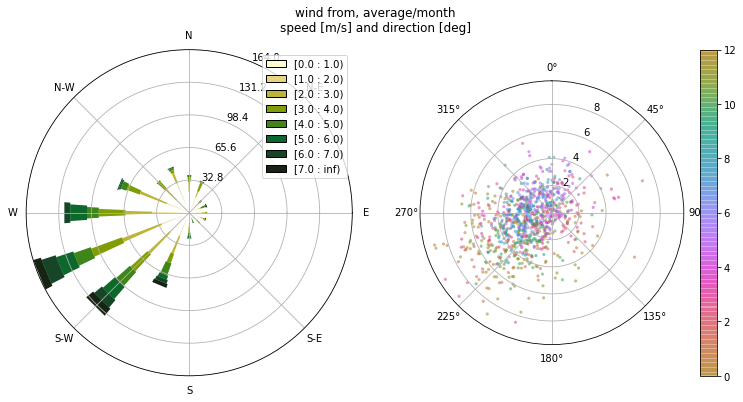

In [14]:
# create a wide figure, showing 2 wind roses with some extra info
fig = plt.figure(figsize=(13, 6))
# we're creating 2 windroses, one boxplot
ax = fig.add_subplot(1, 2, 1, projection='windrose')
ax = windrose.WindroseAxes.from_ax(ax=ax)
# from radians 0 east, ccw to 0 north cw, use meteo convention of "wind from" (270 - math degrees)
# see for example: http://colaweb.gmu.edu/dev/clim301/lectures/wind/wind-uv.html
wind_direction_meteo = np.mod(270 - (360.0 * wind_df.direction / (2*np.pi)), 360)
# create a box plot
ax.box(wind_direction_meteo, wind_df.speed, bins=np.arange(0, 8, 1), cmap=cmocean.cm.speed)
ax.legend(loc='best')

# and a scatter showing the seasonal pattern (colored by month)
ax = fig.add_subplot(1, 2, 2, 
    projection='polar',
    theta_direction=-1,
    theta_offset=np.pi/2.0
)
N = matplotlib.colors.Normalize(1, 12)
months = [x.month for x in wind_df.index]
sc = ax.scatter(
    # here we need radians, but again use math -> meteo conversion
    (np.pi + np.pi/2)-wind_df.direction, 
    wind_df.speed, 
    c=months, 
    cmap=cmocean.cm.phase, 
    vmin=0, 
    vmax=12,
    alpha=0.5,
    s=10,
    edgecolor='none'
)
_ = plt.colorbar(sc, ax=ax)
_ = fig.suptitle('wind from, average/month\nspeed [m/s] and direction [deg]')

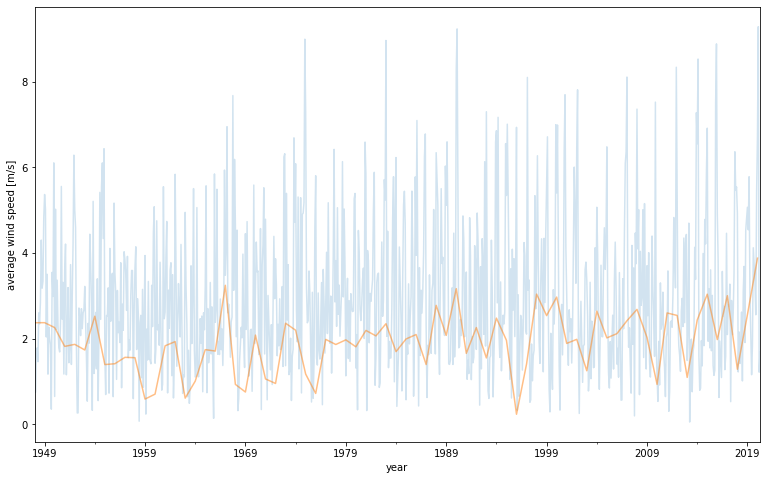

In [15]:
fig, ax = plt.subplots(figsize=(13, 8))
wind_df['speed'].plot(alpha=0.2, ax=ax)
annual_wind_df['speed'].plot(alpha=0.5, ax=ax)
ax.set_xlabel('year')
ax.set_ylabel('average wind speed [m/s]');

In [16]:
def missing2nan(value, missing=-99999):
    """convert the value to nan if the float of value equals the missing value"""
    value = float(value)
    if value == missing:
        return np.nan
    return value

def year2date(year_fraction, dtype='datetime64[s]'):
    """convert a fraction of a year + fraction of a year to a date, for example 1993.12 -> 1993-02-01.
    The dtype should be a valid numpy datetime unit, such as datetime64[s]"""
    startpoints = np.linspace(0, 1, num=12, endpoint=False)
    remainder = np.mod(year_fraction, 1)
    year = np.floor_divide(year_fraction, 1).astype('int')
    month = np.searchsorted(startpoints, remainder)
    if (month == 0).all():
        # if month is set to 0 (for annual data), set to january
        month = np.ones_like(month)
    dates = [
        datetime.datetime(year_i, month_i, 1) 
        for year_i, month_i 
        in zip(year, month)
    ]
    datetime64s = np.asarray(dates, dtype=dtype)
    return datetime64s

In [17]:
def compute_u2v2(df):
    """compute the u2 and v2 based on the direction and alpha"""

    # convert alpha to radians and from North 0, CW to 0 east, CW
    # x * pi / 180 
    alpha_in_rad = np.deg2rad(90 - df['alpha'])
    direction_in_rad = np.arctan2(df['v'], df['u'])
    # these were used in intermediate reports
    df['u2main'] = (wind_df['speed'] ** 2) * np.cos(direction_in_rad - alpha_in_rad)
    df['u2perp'] = (wind_df['speed'] ** 2) * np.sin(direction_in_rad - alpha_in_rad)
    # the squared wind speed components along and perpendicular to the coastline
    df['u2main'].fillna(df['u2main'].mean(), inplace=True)
    df['u2perp'].fillna(df['u2perp'].mean(), inplace=True)
    # we now switched to the signed mean (sometimes the wind comes from the north/east)
    df['u2'] = df['u']**2 * np.sign(df['u'])
    df['v2'] = df['v']**2 * np.sign(df['v'])
    df['u2'].fillna(df['u2'].mean(), inplace=True)
    df['v2'].fillna(df['v2'].mean(), inplace=True)

    return df

In [18]:
def get_data(station, dataset_name):
    """get data for the station (pandas record) from the dataset (url)"""
    info = dict(
        dataset_name=dataset_name,
        id=station.name
    )
    bytes = zipfiles[dataset_name].read(url_names[dataset_name].format(**info))
    df = pd.read_csv(
        io.BytesIO(bytes), 
        sep=';', 
        names=('year', 'height', 'interpolated', 'flags'),
        converters={
            "height": lambda x: station['rlr2nap'](missing2nan(x)),
            "interpolated": str.strip,
        }
    )
    df['station'] = station.name
    df['t'] = year2date(df.year, dtype=wind_df.index.dtype)
    df['alpha'] = station['alpha']
    df = df.set_index('t')
    # merge the wind and water levels
    if 'monthly' in dataset_name:
        merged = pd.merge(df, wind_df, how='left', left_index=True, right_index=True)
    else:
        merged = pd.merge(df, annual_wind_df, how='left', left_index=True, right_index=True)
    merged = compute_u2v2(merged)
    
        
    return merged

In [19]:
# get data for all stations
for dataset_name in psmsl_urls:
    f = functools.partial(get_data, dataset_name=dataset_name)
    # look up the data for each station
    selected_stations[dataset_name] = [f(station) for _, station in selected_stations.iterrows()]

C:\Users\marti_cn\AppData\Local\Continuum\anaconda3\envs\searise\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sign
  result = getattr(ufunc, method)(*inputs, **kwargs)


Now that we have all data downloaded we can compute the mean.

In [20]:
# compute the mean

grouped = pd.concat(selected_stations[dataset_name].tolist())[['year', 'height', 'u2', 'v2']].groupby(['year'])
mean_df = grouped.mean().reset_index()
# filter out non-trusted part (before NAP)
mean_df = mean_df[mean_df['year'] >= 1890].copy()

In [21]:
def timeseries_plot(dataset_name=default_dataset_name):
    # show all the stations, including the mean
    title = 'Sea-surface height for Dutch tide gauges [{year_min} - {year_max}]'.format(
        year_min=mean_df.year.min(),
        year_max=mean_df.year.max() 
    )
    fig = bokeh.plotting.figure(title=title, x_range=(1860, 2020), plot_width=900, plot_height=400)
    colors = bokeh.palettes.Accent7
    # no yellow
    #del colors[3]
    for color, (id_, station) in zip(colors, selected_stations.iterrows()):
        data = station[dataset_name]
        fig.circle(data.year, data.height, color=color, legend=station['name'], alpha=0.5, line_width=1)
    fig.line(mean_df.year, mean_df.height, line_width=1, alpha=0.7, color='black', legend='Mean')
    fig.legend.location = "bottom_right"
    fig.yaxis.axis_label = 'waterlevel [mm] above NAP'
    fig.xaxis.axis_label = 'year'
    fig.legend.click_policy = "hide"
    return fig


In [22]:
bokeh.io.show(timeseries_plot(default_dataset_name))

In [23]:
bokeh.io.show(timeseries_plot('rlr_monthly'))

Methods
=====
Now we can define the statistical model. The "current sea-level rise" is defined by the following formula. Please note that t is relative to the epoch of 1970. This model is referred to as `linear_model` in the code. 
$
H(t) = a + b_{trend}(t) + b_u\cos(2\pi\frac{t}{18.613}) + b_v\sin(2\pi\frac{t}{18.613}) + b_{wind_{u^2}}wind_{u^2}(t) + b_{wind_{v^2}}wind_{v^2}(t) + \varepsilon(t-1) + \varepsilon(t) 
$

The terms are refered to as Constant ($a$), Trend ($b_{trend}$), Nodal U ($b_u$) and Nodal V ($b_v$), Wind ($b_{wind^2}$), the autoregressive term $\varepsilon(t-1)$ and error $\varepsilon$. 


Alternative models are used to detect if sea-level rise is increasing. These models include the broken linear model, defined by a possible change in trend starting at 1993. This timespan is the start of the "satellite era" (start of TOPEX/Poseidon measurements), it is also often referred to as the start of acceleration because the satellite measurements tend to show a higher rate of sea level than the "tide-gauge era" (1900-2000). If this model fits better than the linear model, one could say that there is a "increase in sea-level rise".  This model is refered to as `broken_linear_model`. These models are covered in the section [Sea-level acceleration](#Is-there-a-sea-level-acceleration?).

$
H(t) = a + b_{trend}(t) + b_{broken}(t > 1993)*(t-1993) + b_{u}\cos(2\pi\frac{t}{18.613}) + b_{v}\sin(2\pi\frac{t}{18.613}) + b_{wind_{u^2}}wind_{u^2}(t) + b_{wind_{v^2}}wind_{v^2}(t) + \varepsilon(t-1) + \varepsilon(t) 
$

Another way to look at increased sea-level rise is to look at sea-level acceleration. To detect sea-level acceleration one can use a quadratic model. This model is referred to as `quadratic_model`. 

$
H(t) = a + b_{trend}(t) + b_{quadratic}(t*t) + b_{u}\cos(2\pi\frac{t}{18.613}) + b_{v}\sin(2\pi\frac{t}{18.613}) + b_{wind_{u^2}}wind_{u^2}(t) + b_{wind_{v^2}}wind_{v^2}(t) + \varepsilon(t-1) + \varepsilon(t) 
$



In [24]:
# define the statistical model
def linear_model(df, with_wind=True, with_ar=True):
    y = df['height']
    X = np.c_[
        df['year']-1970, 
        np.cos(2*np.pi*(df['year']-1970)/18.613),
        np.sin(2*np.pi*(df['year']-1970)/18.613)
    ]
    month = np.mod(df['year'], 1) * 12.0
    names = ['Constant', 'Trend', 'Nodal U', 'Nodal V']
    if with_wind:
        X = np.c_[
            X, 
            df['u2'],
            df['v2']
        ]
        names.extend(['Wind $u^2$', 'Wind $v^2$'])
    X = sm.add_constant(X)
    if with_ar:
        model = sm.GLSAR(y, X, missing='drop', rho=1)
    else:
        model = sm.OLS(y, X, missing='drop')
    fit = model.fit(cov_type='HC0')
    return fit, names

We can compare the model with and without wind. Wind drives the storm surge at the coast. If there is a strong wind blowing it can raise the waterlevel by meters, 2 meter is not uncommon. If the wind keeps blowing for two days this will raise the annual averaged waterlevel by more than a centimeter, even if it occurs during low tide. 
We can verify that wind is an important factor for the average sea level by comparing the model with and without wind. 
Things to check for include: 
- Durbin Watson should be >1 for no worries, >2 for no autocorrelation
- JB should be non-significant for normal residuals
- abs(x2.t) + abs(x3.t) should be > 3, otherwise adding nodal is not useful
- The model with wind should also be significant better, check F value difference with 2 and N-5 degrees of freedom. 

In [25]:
# first the model without wind and AR
linear_fit, linear_names = linear_model(mean_df, with_wind=False, with_ar=False)
table = linear_fit.summary(
    yname='Sea-surface height', 
    xname=linear_names, 
    title='Linear model without (1890-current)'
)
IPython.display.display(table)

# and then the model with wind
linear_with_wind_fit, linear_with_wind_names = linear_model(mean_df, with_wind=True, with_ar=True)
table = linear_with_wind_fit.summary(
    yname='Sea-surface height', 
    xname=linear_with_wind_names,
    title='Linear model with wind (1948-current)'
)
IPython.display.display(table)


# Wikipedia, based on Akaike(1974): Given a set of candidate models 
# for the data, the preferred model is the one with the minimum AIC value. 
if (linear_fit.aic < linear_with_wind_fit.aic):
    print('The linear model without wind is a higher quality model (smaller AIC) than the linear model with wind.')
else:
    print('The linear model with wind is a higher quality model (smaller AIC) than the linear model without wind.')



<class 'statsmodels.iolib.summary.Summary'>
"""
                     Linear model without (1890-current)                      
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     286.4
Date:                Mon, 25 May 2020   Prob (F-statistic):           8.24e-56
Time:                        16:46:18   Log-Likelihood:                -616.47
No. Observations:                 129   AIC:                             1241.
Df Residuals:                     125   BIC:                             1252.
Df Model:                           3                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -60.4080      2.882    -20.964      0.000     -66.056     -54.760
Trend          1.9145      0.066     29.219      0.000       1.786       2.043
Nodal U        5.5389      3.683      1.504      0.133      -1.679      12.757
Nodal V      -12.0579      3.478     -3.467      0.001     -18.875      -5.241
==============================================================================
Omnibus:                        2.990   Durbin-Watson:                   1.715
Prob(Omnibus):                  0.224   Jarque-Bera (JB):                2.735
Skew:                          -0.356   Prob(JB):                        0.255
Kurtosis:                       3.023   Cond. No.                         57.6
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Linear model with wind (1948-current)                     
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.908
Model:                          GLSAR   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     358.9
Date:                Mon, 25 May 2020   Prob (F-statistic):           3.64e-71
Time:                        16:46:18   Log-Likelihood:                -582.79
No. Observations:                 128   AIC:                             1178.
Df Residuals:                     122   BIC:                             1195.
Df Model:                           5                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -98.4904      4.583    -21.492      0.000    -107.472     -89.509
Trend          1.8516      0.055     33.650      0.000       1.744       1.959
Nodal U        3.4638      2.835      1.222      0.222      -2.093       9.021
Nodal V      -10.4799      2.946     -3.557      0.000     -16.254      -4.705
Wind $u^2$    10.9267      1.056     10.348      0.000       8.857      12.996
Wind $v^2$     1.6087      2.661      0.605      0.545      -3.606       6.824
==============================================================================
Omnibus:                        2.682   Durbin-Watson:                   1.631
Prob(Omnibus):                  0.262   Jarque-Bera (JB):                2.275
Skew:                          -0.183   Prob(JB):                        0.321
Kurtosis:                       3.540   Cond. No.                         103.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

The linear model with wind is a higher quality model (smaller AIC) than the linear model without wind.


In [28]:
# plot the model with wind. 
fig = bokeh.plotting.figure(x_range=(1860, 2020), plot_width=900, plot_height=400)
fig.circle(mean_df.year, mean_df.height, line_width=1, legend='Monthly mean sea level', color='black', alpha=0.5)
fig.line(
    linear_with_wind_fit.model.exog[:, 1] + 1970, 
    linear_with_wind_fit.predict(), 
    line_width=3, 
    alpha=0.5,
    legend='Current sea level, corrected for wind influence'
)
fig.line(
    linear_fit.model.exog[:, 1] + 1970, 
    linear_fit.predict(), 
    line_width=3, 
    legend='Current sea level', 
    color='green',
    alpha=0.5
)
fig.legend.location = "top_left"
fig.yaxis.axis_label = 'waterlevel [mm] above N.A.P.'
fig.xaxis.axis_label = 'year'
fig.legend.click_policy = "hide"

#export_png(fig, filename="plot.png")

bokeh.io.show(fig)

Regional variability
=====================
It is known that the sea-level rise is not constant along the coast. The figures below show that the sea-level is rising faster at some stations. Some of these variations go back to the 1900's. There are several coastal interventions with known effect to the stations. The construction of the [Afsluitdijk](https://en.wikipedia.org/wiki/Afsluitdijk) (1927-1932), the [Oosterscheldekering](https://en.wikipedia.org/wiki/Oosterscheldekering) (1969-1987), the [Maeslantkering](https://en.wikipedia.org/wiki/Maeslantkering) (1991-1997) all have influence on the mean sea level, mainly due to changes in tidal amplitudes. 

Using the mean of the six tidal guages is the current approach. There are alternatives, for example one can use the principal component of the differences (between months/years). It is then assumed that only the common variance shared accross all stations is representative of the shared sea level. Most of the variance is shared between all stations and this results in a similar trend as using the mean. This method is referred to as EOF, PCA or SSA. See the analysis folder for an example.

In [31]:
p = bokeh.plotting.figure(x_range=(1860, 2020), plot_width=900, plot_height=400)
colors = bokeh.palettes.Accent6

for color, (name, station) in zip(colors, selected_stations.iterrows()):
    df = station[default_dataset_name]
    df = df[df.year >= 1890]
    fit, linear_with_wind_names = linear_model(df, with_wind=True)
    smry = fit.summary(xname=linear_with_wind_names, title=station['name'])
    # somehow a formatted name is not showing up
    print(station['name'])

    IPython.display.display(smry.tables[1])
    p.circle(station[default_dataset_name].year, station[default_dataset_name].height, alpha=0.1, color=color)
# loop again so we have the lines on top
for color, (name, station) in zip(colors, selected_stations.iterrows()):
    df = station[default_dataset_name][station[default_dataset_name].year >= 1890]
    # ignore wind in the plots 
    fit, linear_names = linear_model(df, with_wind=True)
    p.line(
        fit.model.exog[:, 1] + 1970, 
        fit.predict(), 
        line_width=3, 
        alpha=0.8,
        legend=station['name'],
        color=color
    )
p.legend.click_policy = "hide"


bokeh.io.show(p)


Vlissingen


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-97.9035,5.481,-17.861,0.000,-108.647,-87.160
Trend,2.1333,0.070,30.517,0.000,1.996,2.270
Nodal U,4.0450,3.119,1.297,0.195,-2.068,10.158
Nodal V,-12.5471,3.609,-3.477,0.001,-19.621,-5.473
Wind $u^2$,6.3607,1.305,4.875,0.000,3.803,8.918
Wind $v^2$,-1.2976,3.253,-0.399,0.690,-7.674,5.079


Hoek van Holland


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-45.6923,6.377,-7.166,0.000,-58.190,-33.194
Trend,2.3032,0.060,38.584,0.000,2.186,2.420
Nodal U,-0.8038,3.256,-0.247,0.805,-7.185,5.577
Nodal V,-7.8528,3.257,-2.411,0.016,-14.237,-1.469
Wind $u^2$,10.6752,1.535,6.954,0.000,7.666,13.684
Wind $v^2$,2.1492,2.884,0.745,0.456,-3.503,7.802


Den Helder


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-100.7784,4.678,-21.543,0.000,-109.947,-91.610
Trend,1.4441,0.059,24.438,0.000,1.328,1.560
Nodal U,4.1222,2.861,1.441,0.150,-1.484,9.729
Nodal V,-11.3597,3.745,-3.034,0.002,-18.699,-4.020
Wind $u^2$,11.8726,1.068,11.113,0.000,9.779,13.967
Wind $v^2$,1.7021,2.903,0.586,0.558,-3.988,7.392


Delfzijl


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-135.0949,5.440,-24.832,0.000,-145.758,-124.432
Trend,1.9073,0.077,24.812,0.000,1.757,2.058
Nodal U,2.8099,4.213,0.667,0.505,-5.448,11.068
Nodal V,-10.3152,3.675,-2.807,0.005,-17.518,-3.112
Wind $u^2$,13.6273,1.373,9.928,0.000,10.937,16.317
Wind $v^2$,0.7320,3.472,0.211,0.833,-6.074,7.538


Harlingen


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-136.7528,6.058,-22.576,0.000,-148.625,-124.880
Trend,1.2504,0.067,18.657,0.000,1.119,1.382
Nodal U,0.9614,3.561,0.270,0.787,-6.018,7.941
Nodal V,-7.4485,3.484,-2.138,0.033,-14.277,-0.620
Wind $u^2$,14.3617,1.398,10.270,0.000,11.621,17.102
Wind $v^2$,4.2124,3.266,1.290,0.197,-2.189,10.614


IJmuiden


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-74.7202,5.678,-13.161,0.000,-85.848,-63.592
Trend,2.0711,0.075,27.752,0.000,1.925,2.217
Nodal U,9.6484,3.939,2.449,0.014,1.928,17.369
Nodal V,-13.3560,3.771,-3.541,0.000,-20.748,-5.964
Wind $u^2$,8.6627,1.264,6.855,0.000,6.186,11.140
Wind $v^2$,2.1543,3.241,0.665,0.506,-4.198,8.507


Another thing we can look at is the regional variability of unexplained variance. The largest peaks are found in Delfzijl at the start of the measurements. The measured waterlevel was lower in that year. Delfzijl is more affected by storm surges that most other stations due to it's position in the Eems. Another outlier is the measurement in the 30's in Den Helder, this is likely due to the construction of the Afsluitdijk. The other residuals mostly occur on all stations at the same time. This indicates that it is more likely that our estimate of the wind is not optimal yet. We do see a periodicity in the residuals of about 6 years. This does not match with any of the known climate indices. 
Variance descreasess after 1948 because the reanalysis of wind is included after that. 

In [84]:
# TODO:  move this to analysis
nao = pd.read_json('../data/noaa/nao.json')
nao = nao.drop(labels=['missing', 'title'])
nao = nao.reset_index()
nao['date'] = nao['index'].apply(lambda x:  datetime.datetime(year=int(x[:4]), month=int(x[4:6]), day=1))
nao = nao.set_index('date')
nao = nao.rolling(24).mean()

fig, axes = plt.subplots(2, 1, figsize=(13, 8), sharex=True, gridspec_kw=dict(height_ratios=[4,1]))
for i, station_df in selected_stations.iterrows():
    station_df_selected = station_df['rlr_annual'][station_df['rlr_annual']['year'] >= 1890]
    fit, names = linear_model(station_df_selected)
    axes[0].plot(station_df_selected.index, fit.resid, label=station_df['name'])
axes[0].grid(True)
_ = axes[0].legend(loc='best')
axes[1].plot(nao.index, nao['data'])

axes[0].set_ylabel('Sea surface height residual [mm]')
axes[1].set_ylabel('NAO index\n24 year moving average')
fig.savefig('residuals.pdf')

ValueError: Expected object or value

Is there a sea-level acceleration?
==================

The following section computes two common models to detect sea-level acceleration.  The broken linear model expects that sea level has been rising faster since 1990. The quadratic model assumes that the sea-level is accelerating continuously. Both models are compared to the linear model. The extra terms are tested for significance and the AIC is computed to see which model is "better". 

In [32]:

# define the statistical model
def broken_linear_model(df, with_wind=True):
    """This model fits the sea-level rise has started to rise faster in 1993."""
    y = df['height']
    X = np.c_[
        df['year']-1970, 
        (df['year'] > 1993) * (df['year'] - 1993),
        np.cos(2*np.pi*(df['year']-1970)/18.613),
        np.sin(2*np.pi*(df['year']-1970)/18.613)
    ]
    names = ['Constant', 'Trend', '+trend (1993)', 'Nodal U', 'Nodal V']
    if with_wind:
        X = np.c_[
            X, 
            df['u2'],
            df['v2']
        ]
        names.extend(['Wind $u^2$', 'Wind $v^2$'])
    X = sm.add_constant(X)
    model_broken_linear = sm.GLSAR(y, X, rho=1)
    fit = model_broken_linear.iterative_fit(cov_type='HC0')
    return fit, names
broken_linear_fit, broken_names = broken_linear_model(mean_df)

In [33]:
# define the statistical model
def quadratic_model(df, with_wind=True):
    """This model computes a parabolic linear fit. This corresponds to the hypothesis that sea-level is accelerating."""
    y = df['height']
    X = np.c_[
        df['year']-1970, 
        (df['year'] - 1970) * (df['year'] - 1970),
        np.cos(2*np.pi*(df['year']-1970)/18.613),
        np.sin(2*np.pi*(df['year']-1970)/18.613)
    ]
    names = ['Constant', 'Trend', 'Acceleration', 'Nodal U', 'Nodal V']
    if with_wind:
        X = np.c_[
            X, 
            df['u2'],
            df['v2']
        ]
        names.extend(['Wind $u^2$', 'Wind $v^2$'])
    X = sm.add_constant(X)
    model_quadratic = sm.GLSAR(y, X, rho=1)
    fit = model_quadratic.iterative_fit(cov_type='HC0')
    return fit, names
quadratic_fit, quadratic_names = quadratic_model(mean_df)

In [34]:
# summary of the broken linear model
print('rho=%s' % broken_linear_fit.history['rho'][-1])
IPython.display.display(broken_linear_fit.summary(yname='Sea-surface height', xname=broken_names))


rho=[0.18340636]


<class 'statsmodels.iolib.summary.Summary'>
"""
                           GLSAR Regression Results                           
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.877
Model:                          GLSAR   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     219.4
Date:                Mon, 25 May 2020   Prob (F-statistic):           1.54e-62
Time:                        16:53:23   Log-Likelihood:                -579.92
No. Observations:                 128   AIC:                             1174.
Df Residuals:                     121   BIC:                             1194.
Df Model:                           6                                         
Covariance Type:                  HC0                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant        -99.4436      5.297    -18.775      0.000    -109.825     -89.063
Trend             1.7962      0.086     20.948      0.000       1.628       1.964
+trend (1993)     0.5498      0.369      1.489      0.137      -0.174       1.274
Nodal U           3.6638      3.368      1.088      0.277      -2.938      10.265
Nodal V         -10.8623      3.438     -3.159      0.002     -17.602      -4.123
Wind $u^2$       10.8926      1.042     10.455      0.000       8.851      12.935
Wind $v^2$       -0.1056      2.549     -0.041      0.967      -5.102       4.891
==============================================================================
Omnibus:                        2.406   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.300   Jarque-Bera (JB):                2.096
Skew:                          -0.114   Prob(JB):                        0.351
Kurtosis:                       3.584   Cond. No.                         89.3
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [35]:
# summary of the quadratic model
print('rho=%s' % quadratic_fit.history['rho'][-1])

quadratic_fit.summary(yname='Sea-surface height', xname=quadratic_names)

rho=[0.19085552]


<class 'statsmodels.iolib.summary.Summary'>
"""
                           GLSAR Regression Results                           
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.874
Model:                          GLSAR   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     212.6
Date:                Mon, 25 May 2020   Prob (F-statistic):           8.74e-62
Time:                        16:53:25   Log-Likelihood:                -580.43
No. Observations:                 128   AIC:                             1175.
Df Residuals:                     121   BIC:                             1195.
Df Model:                           6                                         
Covariance Type:                  HC0                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Constant       -97.6492      5.331    -18.316      0.000    -108.098     -87.200
Trend            1.8451      0.080     23.182      0.000       1.689       2.001
Acceleration    -0.0002      0.002     -0.096      0.924      -0.004       0.003
Nodal U          3.4663      3.410      1.017      0.309      -3.216      10.149
Nodal V        -10.6189      3.439     -3.088      0.002     -17.358      -3.880
Wind $u^2$      10.8723      1.059     10.270      0.000       8.797      12.947
Wind $v^2$       0.9835      2.673      0.368      0.713      -4.255       6.222
==============================================================================
Omnibus:                        2.589   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.274   Jarque-Bera (JB):                2.322
Skew:                          -0.123   Prob(JB):                        0.313
Kurtosis:                       3.612   Cond. No.                     5.10e+03
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 5.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Constant wind trend
Here we compute the linear model with constant wind and tide

In [36]:
mean_wind = mean_df.set_index('year').loc[1890][['u2', 'v2']]
const = linear_with_wind_fit.params['const'] 
trend = linear_with_wind_fit.params['x1'] 
u2 = linear_with_wind_fit.params['x4'] 
v2 = linear_with_wind_fit.params['x5'] 

# linear_with_wind_fit.predict(mean_df)
linear_with_wind_fit.model.exog.shape, linear_with_wind_fit.model.exog_names
exog_df = pd.DataFrame(
    linear_with_wind_fit.model.exog, 
    columns=linear_with_wind_fit.model.exog_names
).copy()
msg = 'Check variable numbers in code below, they changed'
assert linear_with_wind_names == ['Constant', 'Trend', 'Nodal U', 'Nodal V', 'Wind $u^2$', 'Wind $v^2$'], msg
# take 0 nodal tide
exog_df['x2'] = 0 # 
exog_df['x3'] = 0 # 
# take the average wind
exog_df['x4'] = exog_df['x4'].iloc[0]
exog_df['x5'] = exog_df['x5'].iloc[0]
linear_with_mean_wind = linear_with_wind_fit.predict(exog_df)
linear_with_mean_wind_prediction = linear_with_wind_fit.get_prediction(exog=exog_df)
linear_with_mean_wind_confidence_interval = linear_with_mean_wind_prediction.conf_int(obs=False)
linear_with_mean_wind_prediction_interval = linear_with_mean_wind_prediction.conf_int(obs=True)
linear_with_wind_confidence_interval = linear_with_wind_fit.get_prediction().conf_int(obs=False)
linear_with_wind_prediction_interval = linear_with_wind_fit.get_prediction().conf_int(obs=True)



In [37]:
def model_compare_plot():
    fig = bokeh.plotting.figure(x_range=(1860, 2020), plot_width=900, plot_height=400)
    fig.circle(mean_df.year, mean_df.height, line_width=3, legend='Observed', color='black', alpha=0.5)
    fig.line(mean_df.year, linear_with_wind_fit.predict(), line_width=3, legend='Linear', color='#bbbb33')
    fig.patch(
        np.r_[mean_df.year[::-1], mean_df.year],
        np.r_[linear_with_wind_confidence_interval[::-1, 0], linear_with_wind_confidence_interval[:, 1]],
        color='#bbbb33',
        alpha=0.3,
        legend='Linear'
    )
    fig.patch(
        np.r_[mean_df.year[::-1], mean_df.year],
        np.r_[linear_with_wind_prediction_interval[::-1, 0], linear_with_wind_prediction_interval[:, 1]],
        color='#bbbb33',
        alpha=0.1,
        legend='Linear'
    )
    
    fig.line(mean_df.year, broken_linear_fit.predict(), line_width=3, color='#33bb33', legend='Broken')
    fig.line(mean_df.year, quadratic_fit.predict(), line_width=3, color='#3333bb', legend='Quadratic')
    fig.line(mean_df.year, linear_with_mean_wind, line_width=3, color='#bb33bb', legend='Linear (mean wind)')
    fig.patch(
        np.r_[mean_df.year[::-1], mean_df.year],
        np.r_[linear_with_mean_wind_confidence_interval[::-1, 0], linear_with_mean_wind_confidence_interval[:, 1]],
        color='#bb33bb',
        alpha=0.3, 
        legend='Linear (mean wind)'
    )
    fig.patch(
        np.r_[mean_df.year[::-1], mean_df.year],
        np.r_[linear_with_mean_wind_prediction_interval[::-1, 0], linear_with_mean_wind_prediction_interval[:, 1]],
        color='#bb33bb',
        alpha=0.1, 
        legend='Linear (mean wind)'
    )
    fig.line(mean_df.year, mean_df.height.rolling(18, center=True).mean(), line_width=3, color='#33bb33', legend='Rolling 18 year mean (centered)')

    fig.legend.location = "top_left"
    fig.yaxis.axis_label = 'waterlevel [mm] above N.A.P.'
    fig.xaxis.axis_label = 'year'
    fig.legend.click_policy = "hide"
    return fig
bokeh.io.show(model_compare_plot())

# Export
Here we export the data in csv format. This information is often requested by others.


In [38]:
export_df = mean_df.copy().reset_index()
export_df['predicted_linear_with_wind'] = linear_with_wind_fit.predict()
export_df['predicted_linear'] = linear_fit.predict()
export_df['predicted_linear_mean_wind'] = linear_with_mean_wind
export_df['predicted_linear_mean_wind_ci_025'] = linear_with_mean_wind_confidence_interval[:, 0]
export_df['predicted_linear_mean_wind_ci_975'] = linear_with_mean_wind_confidence_interval[:, 1]
export_df['predicted_linear_mean_wind_pi_025'] = linear_with_mean_wind_prediction_interval[:, 0]
export_df['predicted_linear_mean_wind_pi_975'] = linear_with_mean_wind_prediction_interval[:, 1]
export_df['date'] = export_df['year'].apply(lambda year: datetime.date(year=year, month=1, day=1))
header = """\
# Sea surface height for the Netherlands based on the 6 main tide gauges. 
# Cite https://doi.org/10.2112/JCOASTRES-D-11-00169.1 (method) https://doi.org/10.5281/zenodo.1065964 (data)
# Lineage: https://doi.org/10.5281/zenodo.1065964 (notebooks/dutch-sea-level-monitor.ipynb)
# year -> year over which sea-level is averaged
# date -> first day of the year over which the sea level is averaged
# height -> mean sea surface height over main tide gauges, based on PSMSL RLR [mm relative to NAP(2005)]
# u2/v2 -> signed squared mean wind velocity offshore [m2/s2]
# predicted_linear_with_wind -> fitted sea surface height based on linear model with wind and tide [mm relative to NAP(2005)]
# predicted_linear -> fitted sea surface height based on linear model with tide [mm relative to NAP(2005)]
# predicted_linear_mean_wind  -> fitted sea surface height based on linear model with wind and 0 nodal tide   [mm relative to NAP(2005)]
# predicted_linear_mean_wind_ci_025  -> fitted sea surface height based on linear model with wind and 0 nodal tide, 2.5% confidence interval [mm relative to NAP(2005)]
# predicted_linear_mean_wind_ci_975  -> fitted sea surface height based on linear model with wind and 0 nodal tide, 97.5% confidence interval [mm relative to NAP(2005)]
# predicted_linear_mean_wind_pi_025  -> fitted sea surface height based on linear model with wind and 0 nodal tide, 2.5% prediction interval [mm relative to NAP(2005)]
# predicted_linear_mean_wind_pi_975  -> fitted sea surface height based on linear model with wind and 0 nodal tide, 97.5% prediction interval [mm relative to NAP(2005)]
"""
stream = io.StringIO()
stream.write(header)
export_df.to_csv(stream, escapechar='#', index=False)
date = datetime.datetime.now().date()
path = pathlib.Path('dutch-sea-level-monitor-export-{}.csv'.format(date.isoformat()))
path.write_text(stream.getvalue())

26551

Conclusions
======
Below are some statements that depend on the output calculated above. 

In [39]:
msg = '''The current average waterlevel above NAP (in mm), 
based on the 6 main tide gauges for the year {year} is {height:.1f} cm.
The current sea-level rise is {rate:.0f} cm/century'''
print(msg.format(year=mean_df['year'].iloc[-1], height=linear_fit.predict()[-1]/10.0, rate=linear_fit.params.x1*100.0/10))

The current average waterlevel above NAP (in mm), 
based on the 6 main tide gauges for the year 2018 is 3.2 cm.
The current sea-level rise is 19 cm/century


In [40]:
if (linear_fit.aic < quadratic_fit.aic):
    print('The linear model is a higher quality model (smaller AIC) than the quadratic model.')
else:
    print('The quadratic model is a higher quality model (smaller AIC) than the linear model.')
if (quadratic_fit.pvalues['x2'] < 0.05):
    print('The quadratic term is bigger than we would have expected under the assumption that there was no quadraticness.')
else:
    print('Under the assumption that there is no quadraticness, we would have expected a quadratic term as big as we have seen.')

The quadratic model is a higher quality model (smaller AIC) than the linear model.
Under the assumption that there is no quadraticness, we would have expected a quadratic term as big as we have seen.


In [41]:
if (linear_fit.aic < broken_linear_fit.aic):
    print('The linear model is a higher quality model (smaller AIC) than the broken linear model.')
else:
    print('The broken linear model is a higher quality model (smaller AIC) than the linear model.')
if (broken_linear_fit.pvalues['x2'] < 0.05):
    print('The trend break is bigger than we would have expected under the assumption that there was no trend break.')
else:
    print('Under the assumption that there is no trend break, we would have expected a trend break as big as we have seen.')

The broken linear model is a higher quality model (smaller AIC) than the linear model.
Under the assumption that there is no trend break, we would have expected a trend break as big as we have seen.


In [42]:
# Show trends before and after 1993 for comparison with altimetry
broken_params = dict(zip(broken_names, broken_linear_fit.params.values))
trend_since_1993 = broken_params['Trend'] + broken_params['+trend (1993)']
print('The trend since 1993 is {:.1f} mm/year'.format(trend_since_1993))
print('The trend before 1993 is {:.1f} mm/year'.format(broken_params['Trend']))

The trend since 1993 is 2.3 mm/year
The trend before 1993 is 1.8 mm/year
